## Mouse pancreatic endocrinogenesis (scATAC-seq) | Training with an RNA-dynamics kNN-graph


In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided as a prior for the Graph Layer.
The studied dataset is mouse pancreatic endocrinogenesis multiome (paired scRNA- and scATAC-seq) {cite}`Klein2023`. Raw data available in [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE275562)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [8]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# device = 'cpu'

Using device: cuda:0


In [9]:
import scanpy as sc

In [10]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')
rna.shape, atac.shape

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad
reading ATAC
opening ATAC successful


((16918, 14663), (16918, 228259))

In [11]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


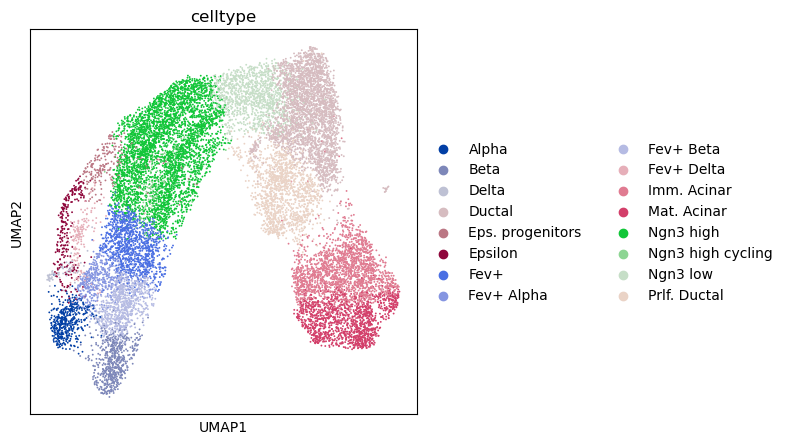

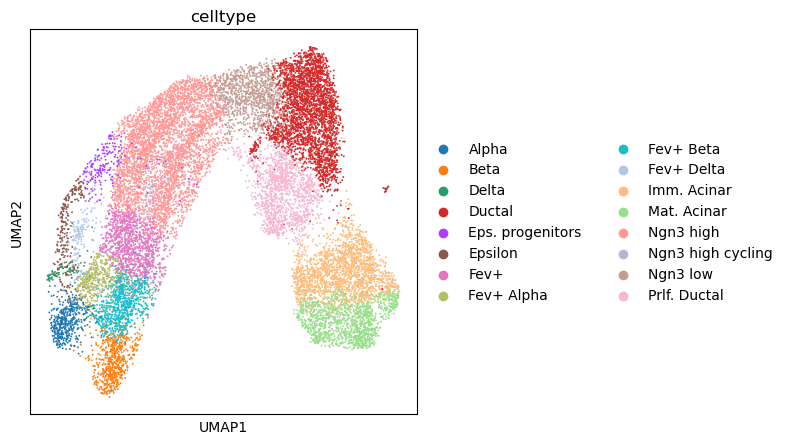

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='celltype')

#ATAC
sc.pl.umap(atac, color='celltype')

In [13]:
atac.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [14]:
# to match the barcode IDs, use the prefix from RNA to match ATAC (anchor = 10 first nucleotides)
assert np.all(rna.obs_names.str[:10] == atac.obs_names.str[:10])
rna.obs_names = atac.obs_names
rna.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

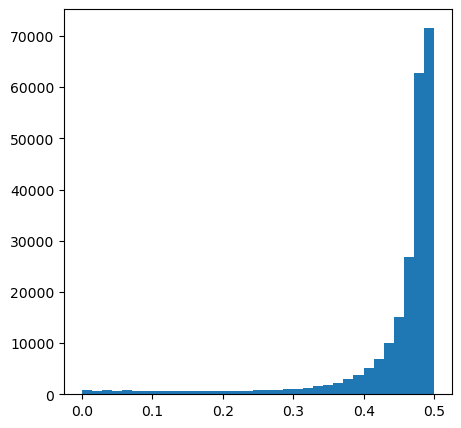

In [15]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [16]:
atac.shape

(16918, 228259)

In [17]:
print('here...')

here...


Number of cells and peaks to use. Lower number for faster training

In [33]:
atac.shape

(16918, 228259)

In [52]:
# n_select = 100
# n_select = atac.shape[0] # 500 # atac.shape[0] # 1500 # atac.shape[0] # 6000
n_select = 18000
n_sample_cells = n_select
# n_sample_peaks = int(n_sample_cells * 3) # atac.shape[1] # int(n_sample_cells * 1.5) # atac.shape[1] # int(n_sample_cells * 1.5)
n_sample_peaks = 50000
print(n_sample_cells, n_sample_peaks)

18000 50000


In [53]:

n_cell_types = len(set(atac.obs['celltype']))

obs_sample = atac.obs.groupby('celltype').sample(int(n_sample_cells / n_cell_types), random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(8521, 50000)

In [20]:
ad.obs['celltype'].value_counts()

celltype
Alpha                6
Beta                 6
Delta                6
Ductal               6
Eps. progenitors     6
Epsilon              6
Fev+                 6
Fev+ Alpha           6
Fev+ Beta            6
Fev+ Delta           6
Imm. Acinar          6
Mat. Acinar          6
Ngn3 high            6
Ngn3 high cycling    6
Ngn3 low             6
Prlf. Ductal         6
Name: count, dtype: int64

In [21]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [22]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(96, 96)

In [23]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

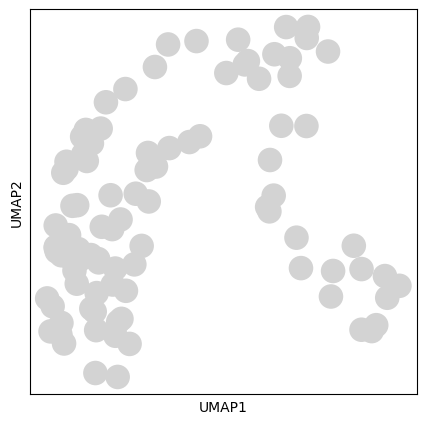

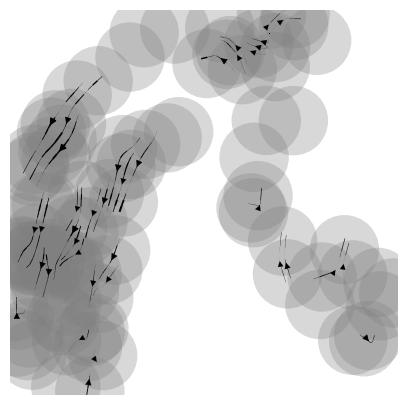

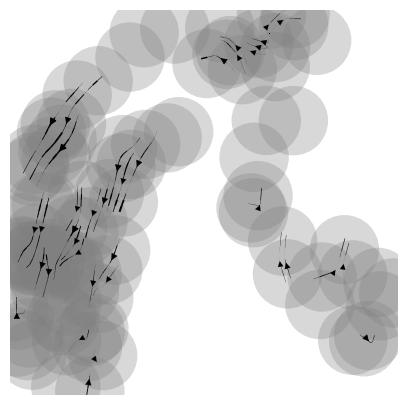

In [24]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [25]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

print('features by chromosome')
extend = 50
ad.var['chr'].value_counts()

features by chromosome


chr
chr4     6
chr11    6
chr6     5
chr1     4
chr5     4
chr3     3
chr7     3
chr16    3
chr13    3
chr18    3
chr10    2
chrX     2
chr17    2
chr9     1
chr15    1
chr12    1
chr14    1
Name: count, dtype: int64

In [26]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [27]:
ad.shape

(96, 50)

In [28]:
n_seqs = ad.shape[1] # 10000 # adata.shape[1] # None # 1000

In [29]:
ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs)

,chr,summit.start,summit.end
1-42487195-42488155,chr1,42487625,42487725
1-62947165-62947608,chr1,62947336,62947436
1-133868944-133869871,chr1,133869357,133869457
1-153480239-153481123,chr1,153480631,153480731
3-67712380-67713308,chr3,67712794,67712894
3-86308558-86309481,chr3,86308969,86309069
3-151566367-151567277,chr3,151566772,151566872
4-11497108-11497964,chr4,11497486,11497586
4-17939150-17940092,chr4,17939571,17939671
4-84309429-84310228,chr4,84309778,84309878


In [30]:
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/.local/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpeu1tpjmg
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/.local/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpeu1tpjmg', '-fo', '/tmp/tmp3xuf1qax']
/home/ilibarra/.local/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmpeu1tpjmg -fo /tmp/tmp3xuf1qax


50

In [31]:
len(seqs)

50

In [32]:
seqs

[['chr1:42487625-42487725',
  'ACCAACAATGTCTATAAATGTTCAGATTGACAGAATGGGTAAATTTTTCTAAAACATTCCTATGCTAAGGGTCTTGGCTTCAACCAGAGGCTGATTTTGC'],
 ['chr1:62947336-62947436',
  'AAGGCTGCCCTCATCTACCTTCCCCTCCCACATCTCAGAGACCTCAGCCCAGCTAGGAAGCATTGGTTTCCAAGCAAGCTACTTCCAGTGTTGCCCAGGT'],
 ['chr1:133869357-133869457',
  'AGCTGCCCATCTGTTCCCTGGACTGCTGGGGTGACAGGCATGTGTTACCACTCTCAGCTCTCACTTGGGTGCTGGGGATATAAACTCAGGTCCTTGTCCC'],
 ['chr1:153480631-153480731',
  'CTAAAGTGACAGATTAGTATATAGTTTTATAATTTGTTCAAGTCAAAACAATAGGATAGATGCTGTAAATTGTGTTTCAGTATTTGTTAGAAACCTGGTC'],
 ['chr3:67712794-67712894',
  'CATCCATTACCCATACAAAGTACATAATAATAAGGACAAGCACTTCATCTCCCTGTGTGACGGCTAGAGGTCAGACACTTGCAGGGCAACACCACACAAG'],
 ['chr3:86308969-86309069',
  'TGGTGGGTATTTGTGTCCACTTCCTGTCTATGCTGGGATTTTTTTCTGGTTTGAATTTGTGTTGGTCTTGTGCATGTTGCTATGTAGTCTCTGTGAGTTC'],
 ['chr3:151566772-151566872',
  'TGACCTTGATGAGATTTTTTTTTTTCCTTCCAGGTGGGTGTAATTTTTAAATTGATAAGCATGACACAACCTTTAGACGATGCTTTAGTGCCACCTGCTG'],
 ['chr4:11497486-11497586',
  'GTACTTTATAATTTTTTT

In [33]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [34]:
ad.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 193 stored elements and shape (96, 50)>

In [35]:
counts.shape

(50, 96)

In [36]:
import scipy


In [62]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [63]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [64]:
next_data.shape

(50, 97)

In [65]:
next_data.shape

(50, 97)

In [66]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(50, 97)

In [67]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(50, 97)

In [68]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [69]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,var
seq,,,,,,,,,,,,,,,,,,,,,
ACCAACAATGTCTATAAATGTTCAGATTGACAGAATGGGTAAATTTTTCTAAAACATTCCTATGCTAAGGGTCTTGGCTTCAACCAGAGGCTGATTTTGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.061404
AAGGCTGCCCTCATCTACCTTCCCCTCCCACATCTCAGAGACCTCAGCCCAGCTAGGAAGCATTGGTTTCCAAGCAAGCTACTTCCAGTGTTGCCCAGGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030592
AGCTGCCCATCTGTTCCCTGGACTGCTGGGGTGACAGGCATGTGTTACCACTCTCAGCTCTCACTTGGGTGCTGGGGATATAAACTCAGGTCCTTGTCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.030592
CTAAAGTGACAGATTAGTATATAGTTTTATAATTTGTTCAAGTCAAAACAATAGGATAGATGCTGTAAATTGTGTTTCAGTATTTGTTAGAAACCTGGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.115351
CATCCATTACCCATACAAAGTACATAATAATAAGGACAAGCACTTCATCTCCCTGTGTGACGGCTAGAGGTCAGACACTTGCAGGGCAACACCACACAAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417
TGGTGGGTATTTGTGTCCACTTCCTGTCTATGCTGGGATTTTTTTCTGGTTTGAATTTGTGTTGGTCTTGTGCATGTTGCTATGTAGTCTCTGTGAGTTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070943
TGACCTTGATGAGATTTTTTTTTTTCCTTCCAGGTGGGTGTAATTTTTAAATTGATAAGCATGACACAACCTTTAGACGATGCTTTAGTGCCACCTGCTG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061404
GTACTTTATAATTTTTTTTCCCTCACAATAAGACTTAGAAATACATAGGTAAAACCAGAATTCCTATATTTCTGTCCTGAAAGGATCCAACTTTTAAATT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040351
TCATCATTTTCTACTTCTTGTTTGTGGATACAATGTGATTAAATCACTCAAGCTCCTGCCACATGGCTTCCTTGGCATGCTAGAACCTAATGTTTGACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030592


In [70]:
# n_cells = next_data.shape[1] # 10000
# top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [71]:
# next_data.index

In [72]:
# next_data = next_data.head(10000)
# next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel = next_data
next_data_sel.shape

(50, 97)

In [73]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [74]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(45, 96)

In [75]:
ad.shape, df.shape

((96, 50), (45, 96))

In [76]:
ad.shape

(96, 50)

In [77]:
ad.shape

(96, 50)

In [78]:
# ad = ad[:,~zero_counts].copy()


In [79]:
print('here...')

here...


In [80]:
# df2 = df.reset_index().melt('seq').set_index('seq')
# # add a baseline count
# df2[0] = 1.0
# cols = ['batch', 1, 0]
# df2.columns = cols
# df2 = df2[[0, 1, 'batch']] # cols[::-1]]
# df2['batch'] = df2['batch'].astype(int)
# print(df2.shape)
# print(len(set(df2['batch'])))
# n_cells = 200
# df2 = df2[df2['batch'].isin(range(0, n_cells))]
# print(df2['batch'].value_counts())
# df2.head()

### Simple motif enrichment

In [81]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [82]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [83]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [84]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [85]:
reduced_groups = pwms

In [86]:
# save for probound
# df.to_csv('probound_input_pancreatic_scatac.csv.gz')

In [87]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)


In [88]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [89]:
len(pwms)

286

In [90]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [91]:
rna_sample.shape, ad.shape

((96, 14663), (96, 50))

In [92]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(96, 96)
setting up log dynamic
no err


In [93]:
for i, batch in enumerate(train):
    # print(i, 'batches out of', n_batches)
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"] # .to(self.device)
    # print(mononuc.shape)

setting up log dynamic
break


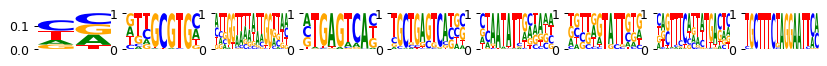

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels 0-69, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.53it/s]


Current time: 2024-08-27 00:03:19.020417
	Loss: 491.408 , R2: 0.053
	Training time (model/function): (5.943s / 5.943s)
		per epoch (model/function): (0.424s/ 0.424s)
		per 1k samples: 9.433s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels 70-139, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.41it/s]


Current time: 2024-08-27 00:03:20.744193
	Loss: 482.798 , R2: 0.053
	Training time (model/function): (7.540s / 1.597s)
		per epoch (model/function): (0.539s/ 0.114s)
		per 1k samples: 2.535s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.67it/s]


Current time: 2024-08-27 00:03:22.590984
	Loss: 245.507 , R2: 0.053
	Training time (model/function): (9.276s / 1.736s)
		per epoch (model/function): (0.663s/ 0.124s)
		per 1k samples: 2.756s
best loss 245.507
last five r2 values, by sequential filter optimization: ['0.053']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels 140-209, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.92it/s]


Current time: 2024-08-27 00:03:24.154004
	Loss: 463.880 , R2: 0.053
	Training time (model/function): (10.653s / 1.377s)
		per epoch (model/function): (0.761s/ 0.098s)
		per 1k samples: 2.186s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.99it/s]


Current time: 2024-08-27 00:03:25.611197
	Loss: 226.356 , R2: 0.053
	Training time (model/function): (12.021s / 1.368s)
		per epoch (model/function): (0.859s/ 0.098s)
		per 1k samples: 2.172s
best loss 226.356
last five r2 values, by sequential filter optimization: ['0.053', '0.053']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels 210-279, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.62it/s]


Current time: 2024-08-27 00:03:27.065108
	Loss: 445.178 , R2: 0.053
	Training time (model/function): (13.314s / 1.294s)
		per epoch (model/function): (0.951s/ 0.092s)
		per 1k samples: 2.053s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.31it/s]


Current time: 2024-08-27 00:03:28.482866
	Loss: 208.615 , R2: 0.053
	Training time (model/function): (14.644s / 1.329s)
		per epoch (model/function): (1.046s/ 0.095s)
		per 1k samples: 2.110s
best loss 208.615
last five r2 values, by sequential filter optimization: ['0.053', '0.053', '0.053']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels 280-349, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.08it/s]


Current time: 2024-08-27 00:03:30.149336
	Loss: 428.727 , R2: 0.053
	Training time (model/function): (16.135s / 1.492s)
		per epoch (model/function): (1.153s/ 0.107s)
		per 1k samples: 2.367s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.05it/s]


Current time: 2024-08-27 00:03:31.756061
	Loss: 193.628 , R2: 0.053
	Training time (model/function): (17.630s / 1.495s)
		per epoch (model/function): (1.259s/ 0.107s)
		per 1k samples: 2.373s
best loss 193.628
last five r2 values, by sequential filter optimization: ['0.053', '0.053', '0.053', '0.053']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9863530232436334, pvalue=1.885508493841139e-75))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 17.63041663169861s
Time per epoch (total): 0.004 s
break


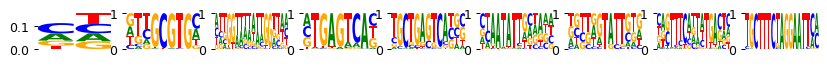

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels 0-69, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.23it/s]


Current time: 2024-08-27 00:03:36.388593
	Loss: 491.360 , R2: 0.058
	Training time (model/function): (1.230s / 1.230s)
		per epoch (model/function): (0.088s/ 0.088s)
		per 1k samples: 1.953s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels 70-139, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.22it/s]


Current time: 2024-08-27 00:03:37.857550
	Loss: 482.791 , R2: 0.063
	Training time (model/function): (2.572s / 1.342s)
		per epoch (model/function): (0.184s/ 0.096s)
		per 1k samples: 2.130s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.56it/s]


Current time: 2024-08-27 00:03:39.990262
	Loss: 245.504 , R2: 0.062
	Training time (model/function): (4.561s / 1.989s)
		per epoch (model/function): (0.326s/ 0.142s)
		per 1k samples: 3.157s
best loss 245.504
last five r2 values, by sequential filter optimization: ['0.062']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels 140-209, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.00it/s]


Current time: 2024-08-27 00:03:41.441683
	Loss: 463.880 , R2: 0.069
	Training time (model/function): (5.815s / 1.254s)
		per epoch (model/function): (0.415s/ 0.090s)
		per 1k samples: 1.990s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.67it/s]


Current time: 2024-08-27 00:03:43.108939
	Loss: 226.352 , R2: 0.067
	Training time (model/function): (7.369s / 1.554s)
		per epoch (model/function): (0.526s/ 0.111s)
		per 1k samples: 2.467s
best loss 226.352
last five r2 values, by sequential filter optimization: ['0.062', '0.068']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels 210-279, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.18it/s]


Current time: 2024-08-27 00:03:44.529860
	Loss: 445.160 , R2: 0.074
	Training time (model/function): (8.604s / 1.235s)
		per epoch (model/function): (0.615s/ 0.088s)
		per 1k samples: 1.961s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.11it/s]


Current time: 2024-08-27 00:03:45.764880
	Loss: 208.608 , R2: 0.073
	Training time (model/function): (9.752s / 1.148s)
		per epoch (model/function): (0.697s/ 0.082s)
		per 1k samples: 1.822s
best loss 208.608
last five r2 values, by sequential filter optimization: ['0.062', '0.068', '0.072']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels 280-349, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.18it/s]


Current time: 2024-08-27 00:03:47.181287
	Loss: 428.700 , R2: 0.076
	Training time (model/function): (10.987s / 1.235s)
		per epoch (model/function): (0.785s/ 0.088s)
		per 1k samples: 1.960s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.46it/s]


Current time: 2024-08-27 00:03:48.607953
	Loss: 193.621 , R2: 0.075
	Training time (model/function): (12.300s / 1.313s)
		per epoch (model/function): (0.879s/ 0.094s)
		per 1k samples: 2.084s
best loss 193.621
last five r2 values, by sequential filter optimization: ['0.062', '0.068', '0.072', '0.076']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9855756636883769, pvalue=2.5036006799198427e-74))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 12.299533128738403s
Time per epoch (total): 0.003 s


In [94]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 15
n_epochs_kernel = 15
log_each=75
n_unfreeze_kernels=70


for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        # assert False
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float).squeeze(1))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model.graph_module.use_hadamard = True
    model, best_loss = model.optimize_iterative(train,
                                                n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False,
                                                use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                rel_chg_early_stop=5e-3,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=4, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

Text(0.5, 0, 'learned etas (per sample)')

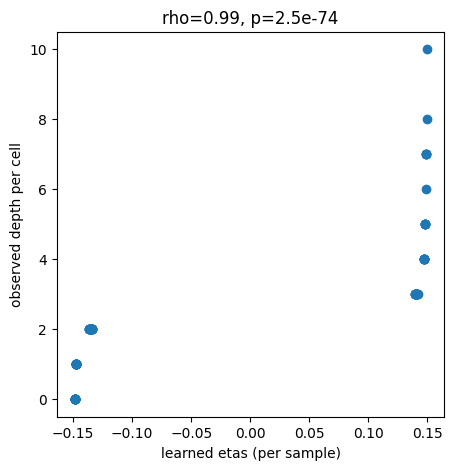

In [95]:
## correlation between etas and observed counts per cell
rcParams['figure.figsize'] = 5, 5
etas = model.get_log_etas()
lib_sizes = train.dataset.rounds.sum(axis=0)
etas.shape, lib_sizes.shape
from scipy.stats import spearmanr

a = etas.detach().cpu().flatten()
b = lib_sizes.flatten()
plt.scatter(a, b)
plt.title('rho=%.2f, p=%.2g' % spearmanr(a, b))
plt.ylabel('observed depth per cell')
plt.xlabel('learned etas (per sample)')

In [96]:
save_output = True

if save_output:
    save_code = '_obs%i_var%i' % (ad.shape[0], ad.shape[1])
    for use_logdynamic in [False, True]:
        p = 'pancreas_multiome_use_logdynamic_%i' % (use_logdynamic) + save_code + '.h5ad'
        print(p)
        torch.save(model_by_logdynamic[use_logdynamic], p)

    ad.write('atac_train%s.h5ad' % save_code)
    rna_sample.write('rna_sample_train%s.h5ad' % save_code)

    import pickle
    pickle.dump(train, open('train_dataloader%s.pkl' % save_code, 'wb'))

pancreas_multiome_use_logdynamic_0_obs96_var50.pth
pancreas_multiome_use_logdynamic_1_obs96_var50.pth


In [63]:
ls -lhtr rna_sample_train_obs8161*

-rwxrwxrwx 1 ilibarra ilibarra 2.6G Aug 30 11:55 rna_sample_train_obs8161.h5ad*


In [58]:
ls -lhtr train_dataloader_obs8161*


-rwxrwxrwx 1 ilibarra ilibarra 1.7G Aug 30 12:19 train_dataloader_obs8161_var50000.pkl*


In [65]:
ls -lhtr atac_train_obs8161*


-rwxrwxrwx 1 ilibarra ilibarra 209M Aug 30 12:10 atac_train_obs8161_var50000.h5ad*


In [67]:
ls -lhtr pancreas*obs8161_var50000*

-rwxrwxrwx 1 ilibarra ilibarra 22M Jul  9 01:22 pancreas_multiome_use_logdynamic_1_obs8161_var50000.pth*
-rwxrwxrwx 1 ilibarra ilibarra 19M Jul  9 01:22 pancreas_multiome_use_logdynamic_0_obs8161_var50000.pth*
